In [180]:
from ortools.sat.python import cp_model

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations, permutations
import time
from sympy import Point, Eq
from sympy.geometry import Line, Segment, Polygon

In [182]:
line1 = Line(Point(0.25,0.25), Point(0.75, 1))

In [183]:
line1.projection(Point(0.2,0.2)) - Point(0.2,0.2)

Point2D(3/260, -1/130)

In [184]:
number_tickets = 10
seating_rows = 20
seating_columns = 20
number_seats = seating_rows * seating_columns
seat_depth = 0.5
seat_depth_gap = 0.2
seat_width = 0.5
seat_width_gap = 0.2
max_group_size = 8

In [185]:
GEOMETRY = "rectangle"
front_row_seat_length = 20
last_row_seat_length = 16

In [186]:
group_size_limits = {
    8 : 1,
    7 : 1,
    6 :1,
    5 : 1,
    4 : 5,
    3 : 8,
    2 : 8,
}

In [187]:
excluded_groups = set([ key if value == 0 else 0 for key, value in group_size_limits.items() ])
excluded_groups.remove(0)
included_groups = set([ value if value not in excluded_groups else 0 for value in range(1, max_group_size + 1)])
included_groups.remove(0)

KeyError: 0

In [188]:
print(excluded_groups)

set()


In [189]:
x_seats = np.array( [ (i % seating_columns) * (seat_width + seat_width_gap) + (seat_width / 2) for i in range(number_seats) ] )

In [190]:
y_seats = np.array( [ (i // seating_columns) * (seat_depth + seat_depth_gap) + (seat_depth / 2) for i in range(number_seats) ] )

In [191]:
#ticket_size = np.random.randint(low =1, high = 10, size = number_tickets)
ticket_size = np.ones(number_tickets)

In [192]:
ticket_size

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [193]:
model = cp_model.CpModel()
model.StringParameters = "num_search_workers:8"

In [194]:
x = {}

In [195]:
def create_pairs(included_groups):
    return combinations(included_groups, 2)

In [196]:
def trapezium_rules():

SyntaxError: unexpected EOF while parsing (<ipython-input-196-c781c36a3916>, line 1)

In [197]:
def is_seat_geometry_excluded(seat_num):
    if GEOMETRY == 'rectanlge':
        return False
    elif GEOMETRY == 'trapezium':
        """line1 = Line( Point(seat_width/2, seat_depth/2), Point( (seating_columns - last_row_seat_length) * (seat_width + seat_width_gap) / 2, (seating_rows - 1) * (seat_depth + seat_depth_gap) ) )
        line = Line( Point(seat_width/2, seat_depth/2), Point(i, j) )
        #return line1.angle_between(line) > 0
        trap = Polygon(
                        Point(seat_width/2, seat_depth/2),
                        Point( 0.5 * (seating_columns - last_row_seat_length) * (seat_width + seat_width_gap) + 0.5 * seat_width, (seating_rows - 1) * (seat_depth + seat_depth_gap) + seating_ ),
                        Point(, (seating_rows - 1) * (seat_depth + seat_depth_gap))
        )"""
        pad = 0.01
        trap = Polygon(
                        Point(x_seats[0]-pad, y_seats[0]-pad),
                        Point(x_seats[seating_columns - 1]+pad, y_seats[seating_columns - 1]-pad),
                        Point(x_seats[int(number_seats - 0.5*(seating_columns - last_row_seat_length))] +pad, y_seats[int(number_seats - 0.5*(seating_columns - last_row_seat_length))]+pad),
                        Point(x_seats[int(number_seats - 0.5*(seating_columns - last_row_seat_length) - last_row_seat_length)] -pad, y_seats[int(number_seats - 0.5*(seating_columns - last_row_seat_length) - last_row_seat_length)]+pad)
        )
        #print(trap.is_convex())
        return trap.encloses_point( Point( x_seats[seat_num], y_seats[seat_num] ))


In [198]:
is_seat_geometry_excluded(5)

In [199]:
def is_seat_group_size_excluded(i, j):
    if i in excluded_groups:
        return True
    else:
        return False

In [200]:
def is_seat_excluded(i, j):
    return is_seat_group_size_excluded(i, j) or is_seat_geometry_excluded(i, j)    

In [201]:
def create_variables(max_group_size):
    for i in included_groups:
        for j in range(number_seats):
            x[(i, j)] = model.NewBoolVar('x[%i,%i]' % (i, j))

In [202]:
c=0
def get_min_distance(a, b, group1, group2):
    c=0
    distances = []
    distances.append((x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2)
    for i in range(group1):
        for j in range(group2):
            try:
                distances.append((x_seats[a+i] - x_seats[b+j])**2 + (y_seats[a+i] - y_seats[b+j])**2)
            except:
                c += 1
                #print(a,b)
    return min(distances)

In [203]:
def create_group_size_constraints(max_group_size):
    for gp in included_groups:
        try:
            model.Add(sum( [ x[gp, j] for j in range(number_seats) ] ) == group_size_limits[gp] ) #chane from equal to lte
        except:
            print("no limit for group size ", gp)

In [204]:
def create_pair_constraints(one, two):
    for a, b in permutations(range(number_seats), 2):
        if get_min_distance(a, b, one, two) < 4:
            model.Add(sum([ x[(one, a)] , x[(two, b)] ]) <= 1)
    

In [205]:
def create_individual_constraints(max_group_size):
    for i in included_groups:
        for j in range(number_seats):
            if j % seating_columns >= seating_columns - i + 1:
                model.Add(x[(i, j)] == 0)

In [206]:
def create_exclusivity_constraints(max_group_size):
    for j in range(number_seats):
        terms = [ x[(i, j)] for i in included_groups ]
        model.Add(sum(terms) <= 1)

In [207]:
def create_all_constraints(max_group_size):
    group_pairs = create_pairs(included_groups)
    for pair in group_pairs:
        create_pair_constraints(pair[0], pair[1])
    
    group_self_pairs = [(d, d) for d in included_groups]
    for pair in group_self_pairs:
        create_pair_constraints(pair[0], pair[1])
        
    create_individual_constraints(max_group_size)
    
    create_exclusivity_constraints(max_group_size)
    
    create_group_size_constraints(max_group_size)
    

In [208]:
def main():
    # Data
    
        
    
    # Solver
    # Create the mip solver with the CBC backend.
    #solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


    # Variables
    
    
    create_variables(max_group_size)
    
    # Constraints
    create_all_constraints(max_group_size)
    
    # Objective
    objective_terms = []
    for j in range(number_seats):
        for i in included_groups:
            objective_terms.append( i * x[(i, j)] )
    
    model.Maximize(sum(objective_terms))
    
    # Solve
    solver = cp_model.CpSolver()
    solver.parameters.num_search_workers = 8
    status = solver.Solve(model)
    
    print("status is ",status)
    c = 0
    #sol_matrix
    sol_matrices = []
    sol_matrices_fmt = []
    for i in range(max_group_size):
        sol_matrices.append(np.zeros((seating_rows, seating_columns)))
        sol_matrices_fmt.append(np.zeros((seating_rows, seating_columns)))
    # Print solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Total cost = ', solver.ObjectiveValue(), '\n')
        for k in range(len(sol_matrices)):
            for i in range(seating_columns):
                for j in range(seating_rows):
                    # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                    try:
                        if solver.BooleanValue(x[(k+1, i + j * seating_columns)]):
                            #print('Worker %d assigned to task %d.  Cost = %d' %
                                  #(i, j, costs[i][j]))

                                sol_matrices[k][j,i] = 1 * (k+1)
                                for m in range(0,k+1):
                                    sol_matrices_fmt[k][j , i + m] = 1 * (k+1)
                    except:
                        c += 1
                    
        return(sol_matrices, sol_matrices_fmt)
    else:
        return status


In [209]:
t1 = time.time()
soln = main()
t2 = time.time()
t2-t1

no limit for group size  1
status is  4
Total cost =  92.0 



251.67739534378052

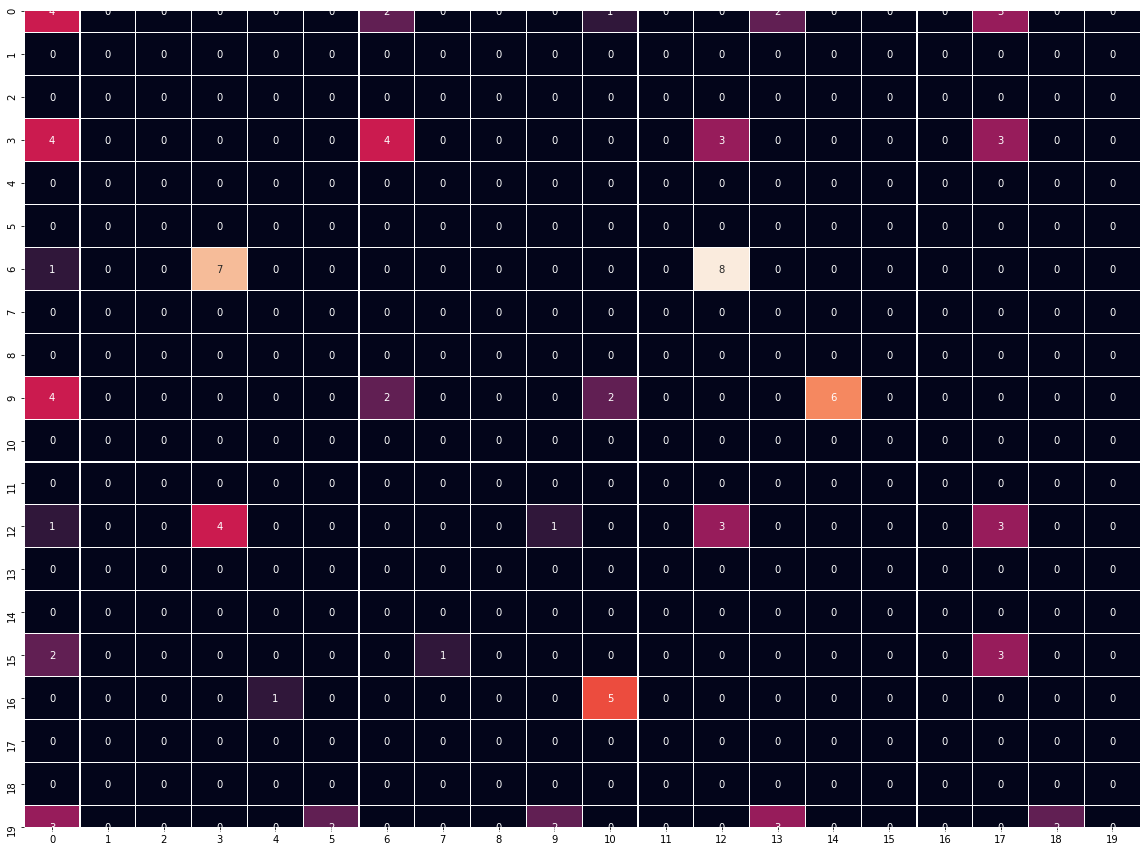

In [210]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(sum(soln[0]), linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

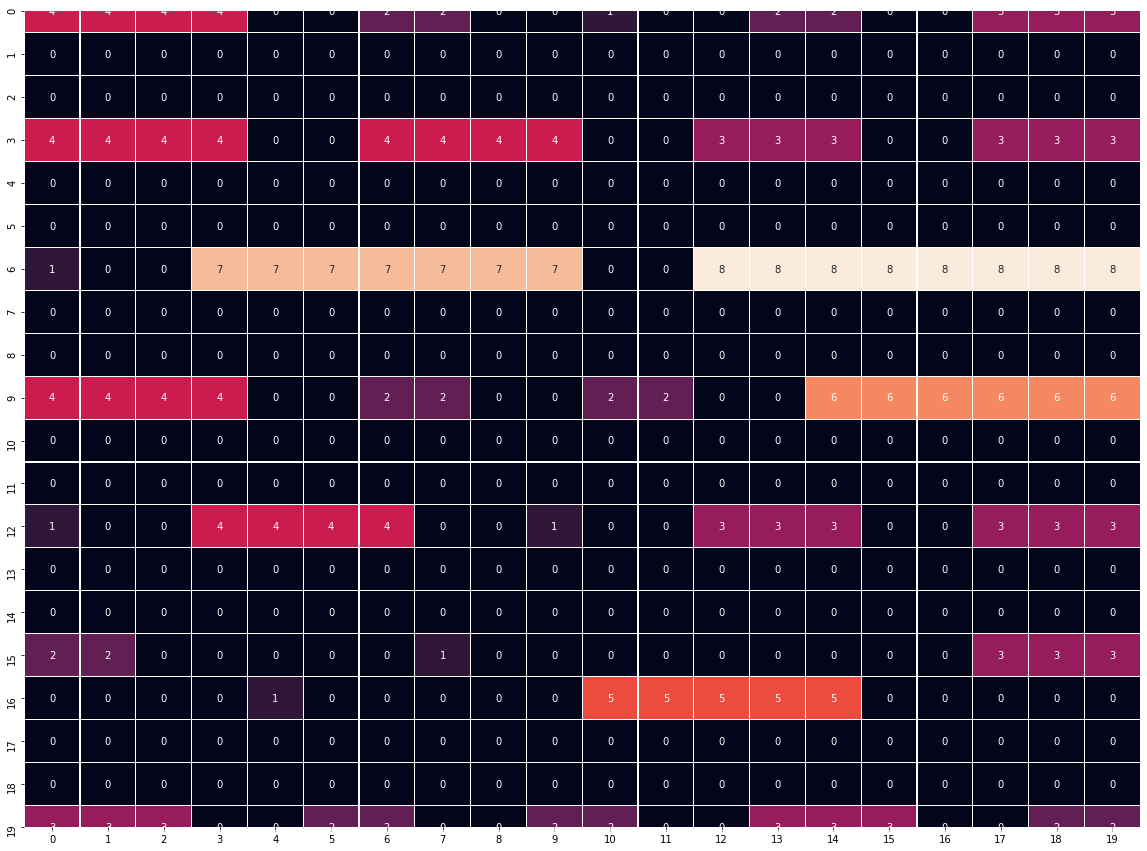

In [211]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(sum(soln[1]), linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

In [212]:
pd.DataFrame(sum(soln[1])).to_csv("seating_optimization_for_400_seats_groups_with_maximization.csv")